## Introductory Machine Learning: Assignment 6

**Deadline:**

Assignment 6 is due Thursday, November 30 at 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on [Canvas](https://canvas.yale.edu).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on [Canvas](https://canvas.yale.edu).  You can also post questions or start discussions on [Ed Discussion](https://edstem.org/us/courses/9209/discussion/). The problems are broken up into steps that should help you to make steady progress.

**Submission:**

Submit your assignment as a .pdf on Gradescope, and as a .ipynb on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to find your complete solution to each problem.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:  
1.  Go to "File" at the top-left of your Jupyter Notebook
2.  Under "Download as", select "HTML (.html)"
3.  After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
4.  From the print window, select the option to save as a .pdf

**Topics**
1. Bayesian inference
2. Topic models

The first two problems test some of the basics of Bayesian inference. The third problem has you building topic models and using them to fit some linear regressions. The fourth problem asks you to build topic models on the UN data.

Note: The assignment looks longer than it really is. We step you through most of the code that you need. But it's still on the long side. Although the assignment is due in three weeks, we encourage you to start early!

In [1]:
# Helper function
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_AREA = 0.5 * 1 * 0.75**0.5
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
# For each corner of the triangle, the pair of other corners
_pairs = [_corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))
def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    coords = np.array([tri_area(xy, p) for p in _pairs]) / _AREA
    return np.clip(coords, tol, 1.0 - tol)
class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                                for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)
def draw_pdf_contours(dist, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `dist`: A distribution instance with a `pdf` method.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)
def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)

### Problem 1: Let the good times roll (10 points)

Consider the scenario of rolling a 4-sided die with the numbers $1$, $2$, $3$, and $4$ on its faces. Suppose we roll this die many times and get a collection of $n$ outcomes represented by $X_{1}, X_{2}, ..., X_{n}$. Here each $X_{i}$ is a random variable that independently follows a Multinomial$(p_{1}, p_{2}, p_{3}, p_{4})$ model (where $p_{1}+p_{2}+p_{3}+p_{4}=1$).

This die may or may not be fair. If it were fair then $p_{1}=p_{2}=p_{3}=p_{4}=0.25$, but since we are uncertain about these parameters we treat them as random and the problem requires Bayesian inference.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot

#### Part (a)

For (a) we will assume that $(p_{1}, p_{2}, p_{3}, p_{4})$ follows a Dirichlet$(\alpha_{1}, \alpha_{2}, \alpha_{3}, \alpha_{4})$ distribution where $\alpha_{1}, \alpha_{2}, \alpha_{3}, \alpha_{4}$ are unknown, positive-valued parameters. Suppose we have a prior belief that the four-sided die is close to being fair. This is represented by $\alpha_{1}= \alpha_{2}= \alpha_{3}= \alpha_{4} = c$ for some positive real number $c$.

For $c = 0.1, 1, 10, 30, 60, 100, 1000$ draw $1000$ samples of $(p_{1}, p_{2}, p_{3}, p_{4})$ from a Dirichlet$(c,c,c,c)$ distribution. For this sample, calculate the mean and standard deviation of $p_{1}$. Create a plot of $log(c)$ vs. the mean and another plot of $log(c)$ vs. the standard deviation. Describe in your own words what happens to these two quantities as $c$ increases.

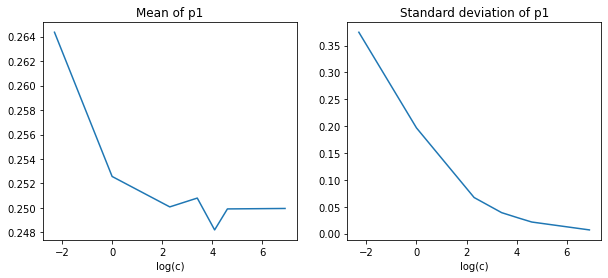

In [3]:
np.random.seed(1012)
c = [0.1,1,10,30,60,100,1000]
x = np.log(c)
n = 1000
sample_mean = np.zeros(len(c))
sample_std = np.zeros(len(c))

for i in np.arange(len(c)):
    alpha = c[i]
    sample_p1 = np.random.dirichlet((alpha, alpha, 
                                     alpha, alpha), n)[:,0]
    sample_mean[i] = np.mean(sample_p1)
    sample_std[i] = np.std(sample_p1)

f, axes = plt.subplots(nrows = 1, ncols = 2, 
                       figsize = (10, 4))
axes = axes.ravel()
axes[0].set_title("Mean of p1")
axes[0].plot(x,sample_mean)
axes[0].set_xlabel("log(c)")
axes[1].set_title(f'Standard deviation of p1')
axes[1].plot(x,sample_std)
axes[1].set_xlabel("log(c)")
plt.show()

By picking every Dirichlet parameter the same, we create a symmetric Dirichlet distribution, which will, on average (expected values), produce a fair die. Note that the figures given in the following explanation will be given for a 3 sided die, as it is possible to visualize a Dirichlet distribution with 3 parameters. The reasoning and answer to this question, however, will be the same for the 4 sided die.

The images below represent the 3D Dirichlet distribution where c takes the values 1, 5, and 30. The color scale runs from dark blue (lowest values and not likely to occur) to red (highest values and very likely to occur). As can be seen in the plots below, the distribution tends toward the center and it becomes more and more tightly concentrated around the center of the simplex. This means we would produce consistently fair dice in the limit as c goes to infinity. For c lower than 1, the distribution concentrates in the corners and along the boundaries of the simplex. A c = 0.1 (not plotted below), will concentrate in the corners, which basically means, p$_1$ consistenently takes the value 1 (on average 25% of the time) or 0 (on average 75% of the time). 

The reason why the distribution becomes more and more concentrated in the center of the simplex is because the probabilities $p_1$ to $p_4$ are powered by a higher and higher exponent. The highest probability, will occur for $p_1$ to $p_4$ all equal to 0.25, but the higher the exponent, the faster the probability will drop to zero for even a small change in the p-values.

For the plot where the mean of a 1000 samples of p1 is taken, it can be seen that the plot oscillates around 0.25 (which is the chance of rolling side 1 if the die is fair) and eventually reaches 0.25. The smaller the value of c, the more further it wil be most of the times be from the value 0.25. If c increases, the mean of p1 becomes closer and closer to 0.25. This corresponds with our explanation above and plots below, as for a higher c the distribution becomes tightly concentrated in the center of the simplex, which basically means that it produces a fair distribution more frequently.

The variance decreases for increasing c, which can be explained by the shape of the Dirichlet distribution for increasing value of c. Due to the fact that the distribution becomes tightly concentrated in the center of the simplex, the variance decreases. 

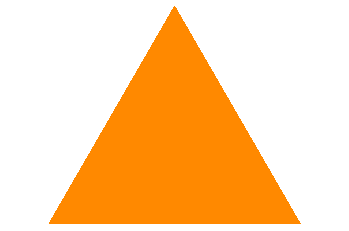

In [4]:
draw_pdf_contours(Dirichlet([1, 1, 1]))

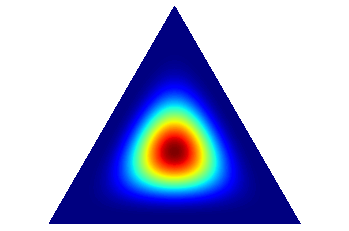

In [5]:
draw_pdf_contours(Dirichlet([5, 5, 5]))

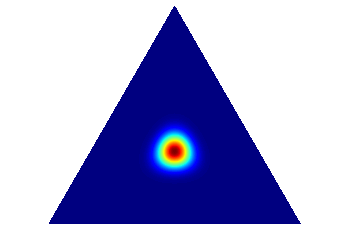

In [6]:
draw_pdf_contours(Dirichlet([30, 30, 30]))

#### Part (b) 

The following cell loads 10,000 rolls for the four-sided die. $[1,0,0,0]$ indicates that the die landed on face $1$, $[0,1,0,0]$ indicates that the die landed on face $2$, and so on. For $c = 0.1, 1, 10, 30, 60, 100, 1000$, use Dirichlet$(c,c,c,c)$ as the prior distribution for $(p_{1}, p_{2}, p_{3}, p_{4})$. *Using only the first $100$ rolls of the die*, calculate the mean of the posterior distribution. What do you notice about the posterior mean as $c$ increases?

Give code to compute the answer and plot the results. Also, give a markdown cell with a mathematical expression for the solution.

Hint: The mean of the Dirichlet$(\alpha_{1}, \alpha_{2}, \alpha_{3}, \alpha_{4})$ is $\left( \dfrac{\alpha_{1}}{\alpha_{1} + \alpha_{2} +\alpha_{3} +\alpha_{4}}, \dfrac{\alpha_{2}}{\alpha_{1} + \alpha_{2} +\alpha_{3} +\alpha_{4}}, \dfrac{\alpha_{3}}{\alpha_{1} + \alpha_{2} +\alpha_{3} +\alpha_{4}}, \dfrac{\alpha_{4}}{\alpha_{1} + \alpha_{2} +\alpha_{3} +\alpha_{4}} \right)$

In [7]:
X = pd.read_pickle('https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/X.pkl')
X

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [8]:
first100 = X[0:100,]
first100_count = np.sum(first100, axis = 0)
c = [0.1,1,10,30,60,100,1000]
post_mean = np.zeros((len(c),4))
for i in np.arange(len(c)):
    sumit = 4 * c[i] + first100.shape[0]
    for j in np.arange(4):
        post_mean[i,j] = (c[i] + first100_count[j])
        /sumit
post_mean

array([[0.2998008 , 0.24003984, 0.17031873, 0.28984064],
       [0.29807692, 0.24038462, 0.17307692, 0.28846154],
       [0.28571429, 0.24285714, 0.19285714, 0.27857143],
       [0.27272727, 0.24545455, 0.21363636, 0.26818182],
       [0.26470588, 0.24705882, 0.22647059, 0.26176471],
       [0.26      , 0.248     , 0.234     , 0.258     ],
       [0.25121951, 0.2497561 , 0.24804878, 0.25097561]])

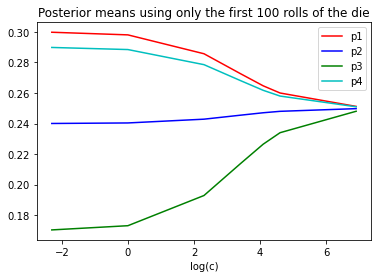

In [9]:
c = [0.1,1,10,30,60,100,1000]
x = np.log(c)     
plt.plot(x, post_mean[:,0], 'r', label = "p1") 
plt.plot(x, post_mean[:,1], 'b', label = "p2") 
plt.plot(x, post_mean[:,2], 'g', label = "p3")  
plt.plot(x, post_mean[:,3], 'c', label = "p4") 
plt.legend(loc="upper right")
plt.title("Posterior means using only the first 100 rolls of the die")
plt.xlabel("log(c)")
plt.show()

From the slides, we know that the Dirichlet distribution is a conjugate prior of a multinomial distribution in Bayesian inference, which means that the posterior distribution will another Dirichlet distribution.

Let's start with defining the prior distribution and the likelihood function, which are respectively given by:

$$
Dirichlet_{c,c,c,c}(p_1, p_2, p_3, p_4) \propto p_1^{c-1}p_2^{c-1}p_3^{c-1}p_4^{c-1}
$$

$$
L(p_1, p_2, p_3, p_4) = p_1^{\#1}p_2^{\#2}p_3^{\#3}p_4^{\#4}
$$

where #1 represents the amounts the die landed on face 1, etc. So #1 + #2 + #3 + #4 = 100.

The posterior can be calculated with Bayes' rule, which leads to an other Dirichlet distribution:

$$
p(p_1, p_2, p_3, p_4|X) \propto p_1^{c-1+\#1}p_2^{c-1+\#2}p_3^{c-1+\#3}p_4^{c-1+\#4}
$$

The mean of the Posterior Dirichlet (for this example) is $\left( \dfrac{c+\#1}{4c + 100}, \dfrac{c+\#2}{4c + 100}, \dfrac{c+\#3}{4c + 100}, \dfrac{c+\#4}{4c + 100} \right)$

**CONCLUSION**

For a very low c (in this case for example 0.1 or 1), the posterior mean is just basically the percentage of how many times each face of the die has been rolled, which is also visible on the plot. This can be explained by the formula above, where it can be seen that a small c does not has a big influence on the mean if 100 rolls are used. The higher c, the more dominant this term will be in the formula above. This is why the plot tends towards 0.25 for every posterior mean.





#### Part (c)

Now repeat the process in Part (b), but with sample sizes $N = 100, 200, 300, ..., 9900, 10000$. For each value of $c$, create a plot that shows the trend of the posterior mean for $p_{1}$ as a function of sample size $N$. Create a similar plot for $p_{2}$, $p_{3}$, and $p_{4}$. Explain what these plots illustrate about the choice of prior and the sample size. What do you estimate were the true parameters used to generate this dataset?

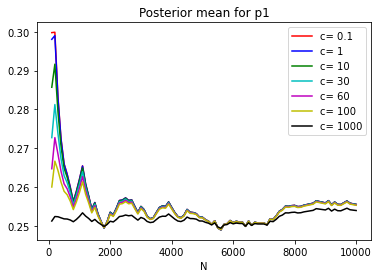

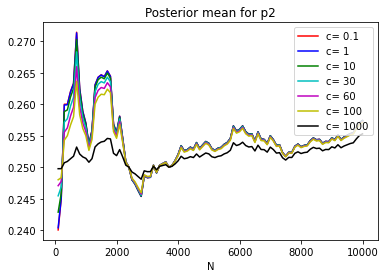

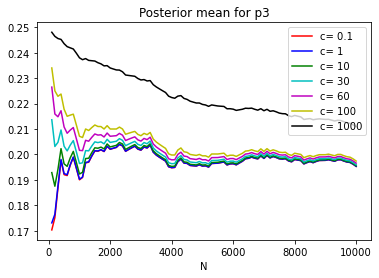

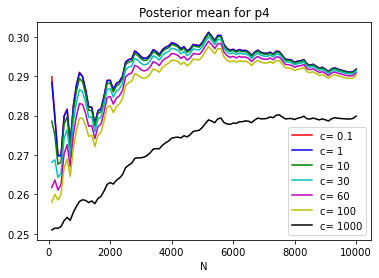

In [10]:
N = np.arange(100, 10100, 100)
c = [0.1,1,10,30,60,100,1000]
p_means = np.zeros((len(N), len(c)))
for m in np.arange(len(N)):
    n = N[m]
    first = X[0:n,]
    first_count = np.sum(first, axis = 0)

    for i in np.arange(len(c)):
        sumit = 4 * c[i] + first.shape[0]
        p_means[m][i] = (c[i] + first_count[0])/sumit  
plt.plot(N, p_means[:,0], 'r', label = "c= 0.1") 
plt.plot(N, p_means[:,1], 'b', label = "c= 1") 
plt.plot(N, p_means[:,2], 'g', label = "c= 10")  
plt.plot(N, p_means[:,3], 'c', label = "c= 30") 
plt.plot(N, p_means[:,4], 'm', label = "c= 60")  
plt.plot(N, p_means[:,5], 'y', label = "c= 100") 
plt.plot(N, p_means[:,6], 'k', label = "c= 1000") 
plt.legend(loc="upper right")
plt.title("Posterior mean for p1")
plt.xlabel("N")
plt.show()
p_means = np.zeros((len(N), len(c)))
for m in np.arange(len(N)):
    n = N[m]
    first = X[0:n,]
    first_count = np.sum(first, axis = 0)

    for i in np.arange(len(c)):
        sumit = 4 * c[i] + first.shape[0]
        p_means[m][i] = (c[i] + first_count[1])/sumit      
plt.plot(N, p_means[:,0], 'r', label = "c= 0.1") 
plt.plot(N, p_means[:,1], 'b', label = "c= 1") 
plt.plot(N, p_means[:,2], 'g', label = "c= 10")  
plt.plot(N, p_means[:,3], 'c', label = "c= 30") 
plt.plot(N, p_means[:,4], 'm', label = "c= 60")  
plt.plot(N, p_means[:,5], 'y', label = "c= 100") 
plt.plot(N, p_means[:,6], 'k', label = "c= 1000") 
plt.legend(loc="upper right")
plt.title("Posterior mean for p2")
plt.xlabel("N")
plt.show()
p_means = np.zeros((len(N), len(c)))
for m in np.arange(len(N)):
    n = N[m]
    first = X[0:n,]
    first_count = np.sum(first, axis = 0)

    for i in np.arange(len(c)):
        sumit = 4 * c[i] + first.shape[0]
        p_means[m][i] = (c[i] + first_count[2])/sumit   
plt.plot(N, p_means[:,0], 'r', label = "c= 0.1") 
plt.plot(N, p_means[:,1], 'b', label = "c= 1") 
plt.plot(N, p_means[:,2], 'g', label = "c= 10")  
plt.plot(N, p_means[:,3], 'c', label = "c= 30") 
plt.plot(N, p_means[:,4], 'm', label = "c= 60")  
plt.plot(N, p_means[:,5], 'y', label = "c= 100") 
plt.plot(N, p_means[:,6], 'k', label = "c= 1000") 
plt.legend(loc="upper right")
plt.title("Posterior mean for p3")
plt.xlabel("N")
plt.show()
p_means = np.zeros((len(N), len(c)))
for m in np.arange(len(N)):
    n = N[m]
    first = X[0:n,]
    first_count = np.sum(first, axis = 0)

    for i in np.arange(len(c)):
        sumit = 4 * c[i] + first.shape[0]
        p_means[m][i] = (c[i] + first_count[3])/sumit       
plt.plot(N, p_means[:,0], 'r', label = "c= 0.1") 
plt.plot(N, p_means[:,1], 'b', label = "c= 1") 
plt.plot(N, p_means[:,2], 'g', label = "c= 10")  
plt.plot(N, p_means[:,3], 'c', label = "c= 30") 
plt.plot(N, p_means[:,4], 'm', label = "c= 60")  
plt.plot(N, p_means[:,5], 'y', label = "c= 100") 
plt.plot(N, p_means[:,6], 'k', label = "c= 1000") 
plt.legend(loc="lower right")
plt.title("Posterior mean for p4")
plt.xlabel("N")
plt.show()

As can be seen on the plots above, the values of each posterior mean for different values of c vary more for lower values of N compared to larger values of N. This is because, for a smaller value of N, the value of c makes a bigger difference. The higher N, the closer each posterior mean (for a different value of c) is to each other. This is, however, not true for c = 1000, where it can be seen that the plots for each posterior mean shows a different behavior than the other values of c. This is meanly because the choice of c is too large in this case, i.e. it will still dominate too much compared to the outcome of the die experiment.

The true parameters used to generate this dataset are estimated to be $p_1 = 0.255$, $p_2 = 0.255$, $p_3 = 0.20$, and $p_4 = 0.29$.

### Problem 2: Toy Story (12 points)

Gibbs sampling is one of the commonly used approach to approximate the inference for Latent Dirichlet Allocation model. In this problem, we will use the toy example from class.

<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/diagram.png" width="500" align="center">

Assume that there are 3 documents and 15 words in the corpus. We would like to build a topic model with 3 topics. The proportions parameter is $\alpha$ and the topic parameter is $\eta$. The table below shows an assignment of topics to words in the toy corpus at one stage of the Gibbs sampling algorithm. 

<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/words.png" width="500" align="center">

Using only these assignment id $Z$ for each word, the following problems ask you 
to calculate the posterior topic proportions for each document, and word probabilities 
for one word in each of the three topics. To answer these questions you only need
to use the basic properties of the Dirichlet distribution as a prior for 
a multinomial, as presented in class (and in the notes on Bayesian inference).


#### Problem 2.1: Per-document topic proportions

Given the $Z$ values in the table, what are the posterior distributions of $\theta_{d}$ for documents $D_{1}$, $D_{2}$ and $D_{3}$ from left to right. Assume the prior over $\theta$ is 
$\mbox{Dirichlet}(\alpha, \alpha, \alpha)$.

$$
P(\theta_1,\theta_2,\theta_3 | D_1) = \theta_1^{\alpha+2} \cdot \theta_2^{\alpha-1} \cdot  \theta_3^{\alpha+1} = \mbox{Dirichlet}(\alpha + 3, \alpha, \alpha + 2)
$$

For the formula above, we found that Document 1 contains three times topic 1, zero times topic 2, and two times topic 3. 

$$
P(\theta_1,\theta_2,\theta_3 | D_2) = \theta_1^{\alpha+1} \cdot \theta_2^{\alpha+2} \cdot  \theta_3^{\alpha-1} = \mbox{Dirichlet}(\alpha + 2, \alpha + 3, \alpha)
$$

For the formula above, we found that Document 2 contains two times topic 1, three times topic 2, and zero times topic 3. 

$$
P(\theta_1,\theta_2,\theta_3 | D_3) = \theta_1^{\alpha-1} \cdot \theta_2^{\alpha+2} \cdot  \theta_3^{\alpha+1} = \mbox{Dirichlet}(\alpha, \alpha + 3, \alpha + 2)
$$

For the formula above, we found that Document 3 contains zero times topic 1, three times topic 2, and two times topic 3. 

#### Problem 2.2: Topics

Here are the 15 words in our corpus:

addiction, brother, baseball, catcher, daughter, divorce, drug, hit, inning, illegal, meth, mother, swing, son, steroids

What is the posterior mean for the probability $p(\mbox{addiction} | \mbox{topic 1})$? 
Assume that the prior distribution over the topics is $\mbox{Dirichlet}(\eta,...\eta)$.

$$
P(addiction|topic \: 1) = \frac{\eta}{5 + 15 \eta}
$$

For the numerator in the equation above, we count how many times topic 1 is assigned to our given word, which is 0 times. In the denominator, we count the total amount of times that topic 1 is used on the words in our corpus, which is 5 times. 

What is the posterior mean of the probability $p(\mbox{baseball}| \mbox{topic 2})$?

$$
P(baseball|topic \: 2) = \frac{2+\eta}{6 + 15 \eta}
$$

For the numerator in the equation above, we count how many times topic 2 is assigned to our given word, which is 2 times. In the denominator, we count the total amount of times that topic 2 is used on the words in our corpus, which is 6 times. 

What is the posterior mean of the probability $p(\mbox{divorce} | \mbox{topic 3})$?

$$
P(divorce|topic \: 3) = \frac{1+\eta}{4 + 15 \eta}
$$

For the numerator in the equation above, we count how many times topic 3 is assigned to our given word, which is 1 times. In the denominator, we count the total amount of times that topic 3 is used on the words in our corpus, which is 4 times. 

## Problem 3: Read before you buy! (30 points)

![zillow](https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/zillow.png)

### Overview of the problem

Here we have a dataset of single family houses sold in Connecticut near the beginning of 2021, collected from [Zillow](https://www.zillow.com/homes/connecticut_rb/). You will build linear models of the price for which each house sold, based on its characteristics given in the real estate listing. Such characteristics include internal square footage, the year it was built, the bedroom count, the bathroom count, and the area of the lot. 

But there is also usually a lengthy description written by the real estate agent. Is there any additional information hidden in this description that would help improve the model of the price? This is the question we focus on in this problem.

Answering such a question is difficult because the description is written in natural language with thousands of different words. Here we use topic models as a dimension reduction technique. Specifically, instead of using thousands of possible words, and how many times they show up in each house description, we reduce the words to the topic proportions $\theta_d$ for each document, obtained by posterior inference. These proportions are combined with the other quantitative variables in a linear model with the logarithm of the house price as the response variable. 

*Important note:* At first glance, this problem looks really long. But this is deceiving. 
After reading in the data, we have you make some plots of the log-transformed variables. 
After that, you just need to run the code that leads up to training a 10-topic topic model, 
and fitting a linear model using the resulting topic proportions. After this, you are asked to compare the results to those obtained with a 3-topic model. To do this, you can simply copy the code used for the 10-topic model. After that, the crux of the problem is to analyze, understand, and describe the results.

Acknowledgment: The data were scraped and the analysis was done by [Parker Holzer](https://parkerholzer.github.io/), as he began his search for a new house for his family after beginning a job as a data scientist. Thanks Parker!


In [53]:
import numpy as np
import pandas as pd
import re
import gensim
from collections import Counter
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

### Read in and clean up the data

In [6]:
%%time
ct_homes = pd.read_csv('https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/ct_zillow.csv')
ct_homes.to_csv("CT_zillow_data.csv", index=False)

CPU times: user 124 ms, sys: 14.6 ms, total: 139 ms
Wall time: 365 ms


In [7]:
ct_homes = pd.read_csv('CT_zillow_data.csv')

In [8]:
ct_homes

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0
...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0


#### Transform the data

We add columns to `ct_homes` called `logAREA`, `logLOTSIZE`, and `logPRICE` that take the logarithms of the corresponding columns in the original data. 


In [55]:
ct_homes['logAREA'] = np.log(ct_homes['AREA'])
ct_homes['logLOTSIZE'] = np.log(ct_homes['LOTSIZE'])
ct_homes['logPRICE'] = np.log(ct_homes['PRICE'])
ct_homes

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159
...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604


#### 3.1 Plot the data 

1. Show histograms of each of the log-transformed columns.

1. Our regression models will use these transformed values. Why might it be preferable to use the logarithms rather than the original data? Explain.


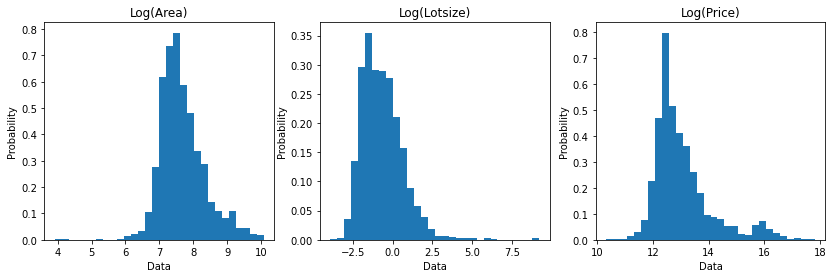

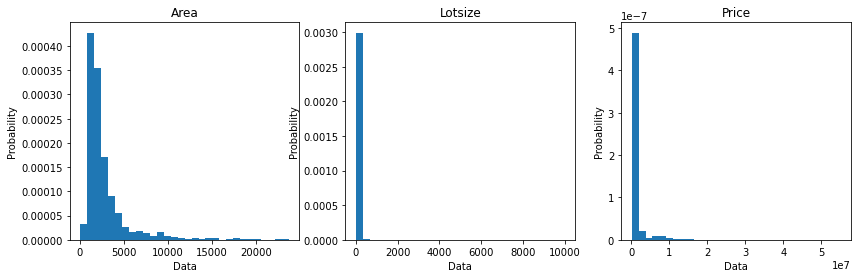

In [56]:
f, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4))
axes = axes.ravel()
axes[0].set_title("Log(Area)")
axes[0].hist(ct_homes['logAREA'], density=True, bins=30)  
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Data')
axes[1].set_title("Log(Lotsize)")
axes[1].hist(ct_homes['logLOTSIZE'], density=True, bins=30)  
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Data')
axes[2].set_title("Log(Price)")
axes[2].hist(ct_homes['logPRICE'], density=True, bins=30)  
axes[2].set_ylabel('Probability')
axes[2].set_xlabel('Data')
f, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4))
axes = axes.ravel()
axes[0].set_title("Area")
axes[0].hist(ct_homes['AREA'], density=True, bins=30)  
axes[0].set_ylabel('Probability')
axes[0].set_xlabel('Data')
axes[1].set_title("Lotsize")
axes[1].hist(ct_homes['LOTSIZE'], density=True, bins=30)  
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Data')
axes[2].set_title("Price")
axes[2].hist(ct_homes['PRICE'], density=True, bins=30)  
axes[2].set_ylabel('Probability')
axes[2].set_xlabel('Data')
plt.show()

If one observes the original data of Area, Lotsize and Price, it can be seen that they are all very strongly positively skewed. This, for example, means we have a lot of houses which have small Areas or Lotsizes, and a couple of houses with large Areas or Lotsizes (but this does not mean they are outliers). To create a more symmetrical data-distribution, a log-distribution should be taken. This will also make sure that the residuals are more symmetrically distributed around zero and to achieve more homoscedasticity in the spread of the residuals. The previous two charachteristics are assumptions of the linear regression model.

This log-transformation can also make the interpretation easier, for example: a 1\% increase in Area would lead to a ceteris paribus $\beta_{Area}$ \% increase in the Costs (on average). 

Let's look at one of the descriptions as an example.

In [57]:
example = 9
ct_homes["DESCRIPTION"][example]

"One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenient features include front and rear staircas

#### Helper functions

The following two functions will be used to clean up the text a bit and separate into tokens

In [58]:
def cleanup_description(desc):
    if type(desc) == float:
        desc = ""
    words = [re.sub(r'[^a-z]', '', 
                    w) for w in desc.lower().split(' ')]
    return ' '.join(words)

def reduce_to_vocabulary(desc, vocab):
    return ' '.join([w for w in 
                     cleanup_description(desc).split(' ') 
                     if w in vocab])

In [59]:
cleanup_description(ct_homes['DESCRIPTION'][example])

'one of ridgefields most admired homes custom built with absolutely no expense spared stunning stone and clapboard new england colonial with exceptional architectural details throughout beautifully sited on  parklike acres the heart of this home features an updated gourmet kitchen with dacor double ovens viking cook top and sub zero refrigerator gorgeous taj mahal quartz counters and island with tumbled limestone back splash stylish living room with propane fireplace and spacious dining room with large butlers pantry also with quartz and tumbled marble handsome cherry paneled library and sun filled family room with fireplace and builtin cabinets and desk the upper level features a large master suite with custom marble bath and generous walkin closet three bedrooms are en suite and two bedrooms share a lovely jack n jill bathroom large custom laundry room and over sized bonus room round out the second floor other convenient features include front and rear staircases mud room with builti


#### Next we build a vocabulary of words

In [60]:
# This will create a dictionary with the count for 
# Every word in the data set.
vocab = Counter()
for dsc in ct_homes['DESCRIPTION']:
    vocab.update(cleanup_description(dsc).split(' '))

In [61]:
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 9738


#### Remove words that are either too common or too rare

In [62]:
vocab = Counter(token for token in vocab.elements() 
                if vocab[token] > 5)
stop_words = [item[0] for item 
              in vocab.most_common(50)]
vocab = Counter(token for token in vocab.elements() 
                if token not in stop_words)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 2540


#### Build a mapping between unique words and integers

In [63]:
desc = ct_homes['DESCRIPTION'][example]
print('Original description:\n---------------------')
print(desc)

print('\nCleaned up text:\n----------------')
print(cleanup_description(desc))

print('\nReduced to vocabulary:\n----------------------')
print(reduce_to_vocabulary(desc, vocab))

Original description:
---------------------
One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenie

#### Build a mapping between unique words and integers

In [64]:
id2word = {idx: pair[0] for idx, pair in enumerate(vocab.items())}
word2id = {pair[0]: idx for idx, pair in enumerate(vocab.items())}

s = 'nyc'
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for '%s': %d" % (s,word2id[s]))
print("Word for identifier %d: %s" % (word2id[s], 
                                      id2word[word2id[s]]))

Number of tokens mapped: 2540
Identifier for 'nyc': 477
Word for identifier 477: nyc


#### Map to word id format

Now, use the format required to build a language model, mapping each word to its id, 

In [65]:
tokens = []
for dsc in ct_homes['DESCRIPTION']:
    clean = reduce_to_vocabulary(cleanup_description(dsc), 
                                 vocab)
    toks = clean.split(' ')
    tokens.append(toks)

In [66]:
corpus = []
for toks in tokens:
    tkn_count = Counter(toks)
    corpus.append([(word2id[item[0]], item[1]) for item 
                   in tkn_count.items()])
    
dsc = ct_homes['DESCRIPTION'][example]
clean = reduce_to_vocabulary(cleanup_description(dsc), 
                             vocab)
toks = clean.split(' ')
print("Abstract, tokenized:\n", toks, "\n")
print("Abstract, in corpus format:\n", corpus[10])

Abstract, tokenized:
 ['one', 'most', 'homes', 'custom', 'built', 'absolutely', 'no', 'expense', 'spared', 'stunning', 'stone', 'clapboard', 'england', 'colonial', 'exceptional', 'architectural', 'details', 'throughout', 'beautifully', 'sited', 'parklike', 'acres', 'heart', 'updated', 'gourmet', 'dacor', 'double', 'ovens', 'viking', 'cook', 'top', 'sub', 'refrigerator', 'gorgeous', 'quartz', 'counters', 'island', 'limestone', 'back', 'splash', 'stylish', 'propane', 'spacious', 'butlers', 'pantry', 'also', 'quartz', 'marble', 'handsome', 'cherry', 'paneled', 'library', 'sun', 'filled', 'builtin', 'cabinets', 'desk', 'upper', 'suite', 'custom', 'marble', 'generous', 'walkin', 'closet', 'three', 'are', 'en', 'suite', 'two', 'share', 'lovely', 'jack', 'n', 'jill', 'bathroom', 'custom', 'laundry', 'over', 'sized', 'bonus', 'round', 'out', 'second', 'other', 'convenient', 'include', 'front', 'rear', 'staircases', 'mud', 'builtins', 'pantry', 'utility', 'closets', 'finished', 'lower', 'second

#### Build a Topic Model with 10 topics

Note: Don't worry about the various settings used in the call to `LdaModel`. If you want to read up on these, just check out the documentation. 


In [67]:
%%time
tm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=10, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

CPU times: user 3.66 s, sys: 2.78 ms, total: 3.66 s
Wall time: 3.66 s


In [68]:
num_topics = 10
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,1,create,property,spacious,waterfront,north,will,beach,guests,farm,custom
1,2,architect,it,additional,ft,boasts,roof,water,solar,farmhouse,suite
2,3,premier,own,main,sq,provides,well,sound,panels,antique,island
3,4,indoor,location,perfect,milford,state,have,views,rock,cheshire,by
4,5,shaker,at,bathroom,unique,morning,newer,long,metro,trees,pool
5,6,kayaks,can,two,built,fire,one,miles,salt,better,views
6,7,acreage,opportunity,lower,construction,many,water,post,masterpiece,association,stone
7,8,restored,close,finished,if,garden,been,steps,energy,chestnut,built
8,9,beginning,town,throughout,yale,work,by,directly,amp,original,ceilings
9,10,ny,come,beautiful,barn,coffee,ranch,across,service,historic,stunning


In [69]:
topic_dist = tm.get_document_topics(corpus[example])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,1,0.044949
1,2,0.308955
2,3,0.013631
3,4,0.014789
4,5,0.034338
5,9,0.568486


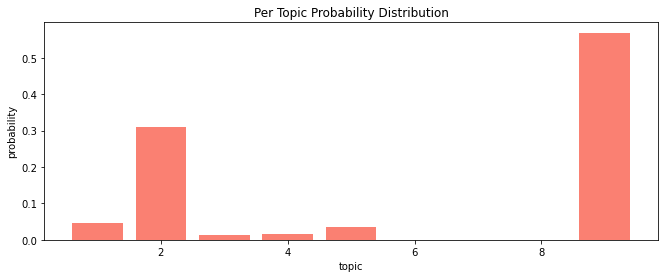

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], 
        topic_dist_table['Probabilities'], 
        align='center', alpha=1, 
        color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

### Include the topic proportions $\theta_d$ for each house 


In [71]:
num_topics = 10
theta = pd.DataFrame({"Theta0": np.zeros(ct_homes.shape[0])})
for t in np.arange(1,num_topics):
    theta["Theta"+str(t)] = np.zeros(ct_homes.shape[0])
    
for i in np.arange(ct_homes.shape[0]):
    for t in tm.get_document_topics(corpus[i]):
        theta.loc[i,"Theta"+str(t[0])] = t[1]

In [72]:
ct_topics = ct_homes.join(theta)
ct_topics

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE,Theta0,Theta1,Theta2,Theta3,Theta4,Theta5,Theta6,Theta7,Theta8,Theta9
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401,0.000000,0.217734,0.307562,0.013005,0.015983,0.276440,0.000000,0.068734,0.0,0.090220
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856,0.058219,0.071381,0.402323,0.012686,0.015575,0.241166,0.000000,0.132528,0.0,0.056359
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411,0.000000,0.585885,0.156176,0.010631,0.016616,0.139861,0.033774,0.019388,0.0,0.030921
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258,0.018890,0.024961,0.828652,0.000000,0.010878,0.073782,0.000000,0.000000,0.0,0.030547
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159,0.000000,0.066091,0.488584,0.000000,0.036447,0.311831,0.000000,0.000000,0.0,0.076273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308,0.019154,0.141277,0.446502,0.026240,0.028841,0.262196,0.000000,0.018545,0.0,0.048959
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367,0.025282,0.041325,0.539178,0.015925,0.059542,0.115156,0.075164,0.000000,0.0,0.118585
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762,0.000000,0.273471,0.136182,0.102197,0.023975,0.144641,0.098131,0.000000,0.0,0.212532
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604,0.012756,0.360858,0.187796,0.103612,0.023432,0.108213,0.016014,0.012044,0.0,0.172680


#### Fit a linear model with the topic proportions included

We now fit a linear model with the topic proportions included. Note that 
the proportions satisfy $\theta_0+\theta_1+\cdots + \theta_9 = 1$. Therefore, we remove one of them, since it is redundant. If we don't do this the linear model will be harder to interpret!


In [73]:
model = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT + Theta0 + " +
               "Theta1 + Theta2 + Theta3 + Theta4 + Theta5 + Theta6 + Theta7 + Theta8", data=ct_topics).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     769.3
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:44:17   Log-Likelihood:                -1036.1
No. Observations:                1926   AIC:                             2102.
Df Residuals:                    1911   BIC:                             2186.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0959      0.529     17.190      0.000       8.058      10.134
logAREA        0.4800      0.033     14.571      0.000       0.415       0.545
logLOTSIZE     0.0496      0.009      5.319      0.000       0.031       0.068
BED           -0.0081      0.013     -0.644      0.519      -0.033       0.017
BATH           0.1460      0.010     14.585      0.000       0.126       0.166
BUILT          0.0008      0.000      3.598      0.000       0.000       0.001
Theta0         1.7751      0.631      2.814      0.005       0.538       3.012
Theta1        -2.4646      0.163    -15.093      0.000      -2.785      -2.144
Theta2        -2.2093      0.140    -15.758      0.000      -2.484      -1.934
Theta3        -1.0790      0.301     -3.579      0.000      -1.670      -0.488
Theta4        -1.9870      0.294     -6.763      0.000      -2.563      -1.411
Theta5        -2.3583      0.149    -15.820      0.000      -2.651      -2.066
Theta6         3.9929      0.465      8.578      0.000       3.080       4.906
Theta7        -1.0803      0.650     -1.662      0.097      -2.355       0.194
Theta8         0.6659      0.513      1.299      0.194      -0.340       1.671
==============================================================================
Omnibus:                      127.152   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.901
Skew:                           0.247   Prob(JB):                     1.49e-97
Kurtosis:                       5.305   Cond. No.                     1.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

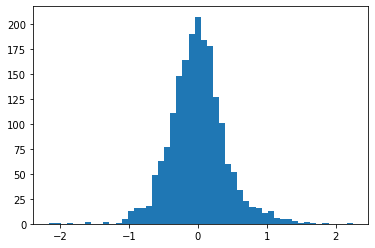

In [74]:
plt.hist(model.resid, bins=50)
plt.show()

### Model without the topics included

In [75]:
model_without_topics = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT", data=ct_topics).fit()
model_without_topics.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     1417.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:44:19   Log-Likelihood:                -1370.4
No. Observations:                1926   AIC:                             2753.
Df Residuals:                    1920   BIC:                             2786.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9172      0.528     11.203      0.000       4.881       6.953
logAREA        0.7285      0.035     20.723      0.000       0.660       0.797
logLOTSIZE     0.0673      0.010      6.481      0.000       0.047       0.088
BED           -0.0620      0.015     -4.214      0.000      -0.091      -0.033
BATH           0.2373      0.011     21.734      0.000       0.216       0.259
BUILT          0.0006      0.000      2.249      0.025    7.19e-05       0.001
==============================================================================
Omnibus:                      271.078   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.510
Skew:                           0.705   Prob(JB):                    3.10e-188
Kurtosis:                       5.961   Cond. No.                     9.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 3.2 Plot the residuals

On a single plot, show a histogram of the residuals of the model without the topics, 
and the residuals of the model with the topics. Give a legend that shows which is which.
Comment on the results. 


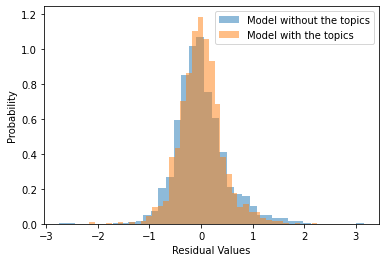

In [76]:
y_mod_10top = model.resid
y_mod_notop = model_without_topics.resid

plt.hist(y_mod_notop, density=True, bins=40, 
         label = "Model without the topics", alpha=0.5)
plt.hist(y_mod_10top, density=True, bins=40, 
         label = "Model with the topics", alpha=0.5) 
plt.xlabel("Residual Values")
plt.ylabel("Probability")
plt.legend(loc="upper right")

plt.show()

When comparing the histograms of the residuals of the model without the topics, and the residuals of the model with the topics, it can be seen that the model with the topic has a slightly narrower probability distribution (slightly higher peak and slightly lower variance). This means that the model with the topics included did a better job at predicting the real prices, as more residuals are closer to zero.

#### 3.3 Quantify the improvement: R-squared

How do the two models compare in terms of R-squared? What do these numbers mean?


In [77]:
print("The adjusted R-squared for the model without the topics is:",
      round(model_without_topics.rsquared_adj,3))
print("The adjusted R-squared for the model with the topics is:",
      round(model.rsquared_adj,3))

The adjusted R-squared for the model without the topics is: 0.786
The adjusted R-squared for the model with the topics is: 0.848


The R-squared value gives the proportion of the variance in the costs (the response variable) that can be explained by the predictor variables. As a consequence, we want it as close as possible to 1. It was chosen to use the adjusted R-squared value, as it corrects for the amount of predictor variables included in the model (although it doesn't make a big difference in this case). 

The adjusted R-squared value for the model with the topics is higher for this problem, which means the topics should be included in the model, as they help with explaining a proportion of the variance in the costs.

#### 3.4 Quantify the improvement: MSE decrease

What is the percent decrease in the mean-squared-error of the model with the topics
compared to the model that ignores the descriptions?


In [78]:
mse_notop = model_without_topics.mse_resid
mse_top = model.mse_resid

(mse_top - mse_notop)/mse_notop

-0.2899845150024754

#### 3.5 Quantify the improvement: LOOCV

What is the percent decrease in the leave-one-out-cross-validation (LOOCV) error?
Recall from class that the following formula can be used to calculate this:

<img src="https://raw.githubusercontent.com/YData123/sds265-fa21/main/assignments/assn6/loocv.png" width="410" align="center">

<br>

The following line of code computes this for one of the models:

`np.mean((model.resid/(1 - model.get_influence().hat_matrix_diag))**2)`

In [79]:
LOOCV_notop = np.mean((model_without_topics.resid/
                       (1 - model_without_topics.get_influence().hat_matrix_diag))**2)
LOOCV_top = np.mean((model.resid/
                     (1 - model.get_influence().hat_matrix_diag))**2)
(LOOCV_top - LOOCV_notop)/LOOCV_notop

-0.28447675047614945

#### 3.6 Repeat for three topics 

Now, repeat the above steps for a topic model that is trained using only three (3) topics. Specifically:

1. Train a model with three topics
1. Display the top words in each of the three topics
1. Augment the `ct_homes` data with the resulting topic proportions $\theta$
1. Fit a linear model *using only the first two of the three* proportions
1. Plot a histogram of the residuals of the three linear models together
1. Comment on the improvement over the baseline in terms of R-squared, MSE, and LOOCV compared with the previous two models.


##### 1) Train a model with three topics

In [80]:
%%time
tm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=3, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

CPU times: user 4.83 s, sys: 3.71 ms, total: 4.83 s
Wall time: 4.83 s


##### 2) Display the top words in each of the three topics

In [81]:
num_topics = 3
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2
0,1,views,property,spacious
1,2,beach,it,additional
2,3,island,will,main
3,4,suite,can,appliances
4,5,custom,located,throughout
5,6,by,are,lower
6,7,sound,at,yard
7,8,pool,one,beautiful
8,9,waterfront,own,bathroom
9,10,stone,location,granite


##### 3) Augment the ct_homes data with the resulting topic proportions 
 

In [82]:
topic_dist = tm.get_document_topics(corpus[example])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,0,0.463492
1,1,0.020958
2,2,0.515550


In [83]:
num_topics = 3
theta = pd.DataFrame({"Theta0": np.zeros(ct_homes.shape[0])})
for t in np.arange(1,num_topics):
    theta["Theta"+str(t)] = np.zeros(ct_homes.shape[0])
    
for i in np.arange(ct_homes.shape[0]):
    for t in tm.get_document_topics(corpus[i]):
        theta.loc[i,"Theta"+str(t[0])] = t[1]
        
ct_topics = ct_homes.join(theta)
ct_topics

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE,Theta0,Theta1,Theta2
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401,0.056830,0.341755,0.601415
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856,0.000000,0.288069,0.704742
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411,0.000000,0.878319,0.116560
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258,0.000000,0.066718,0.930361
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159,0.000000,0.204541,0.790524
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308,0.000000,0.216580,0.777554
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367,0.334035,0.018248,0.647717
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762,0.406171,0.579553,0.014277
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604,0.394665,0.588742,0.016593


##### 4) Fit a linear model using only the first two of the three proportions

In [84]:
model3 = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT + Theta0 + " +
               "Theta1", data=ct_topics).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1759.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:44:50   Log-Likelihood:                -928.66
No. Observations:                1926   AIC:                             1873.
Df Residuals:                    1918   BIC:                             1918.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6473      0.445     14.937      0.000       5.774       7.520
logAREA        0.4098      0.030     13.543      0.000       0.350       0.469
logLOTSIZE     0.0263      0.008      3.136      0.002       0.010       0.043
BED            0.0039      0.012      0.331      0.741      -0.019       0.027
BATH           0.1163      0.009     12.271      0.000       0.098       0.135
BUILT          0.0013      0.000      6.584      0.000       0.001       0.002
Theta0         2.0158      0.063     31.859      0.000       1.892       2.140
Theta1        -0.2029      0.038     -5.303      0.000      -0.278      -0.128
==============================================================================
Omnibus:                      143.830   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.943
Skew:                           0.285   Prob(JB):                    2.54e-117
Kurtosis:                       5.523   Cond. No.                     9.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### 5) Plot a histogram of the residuals of the three linear models together

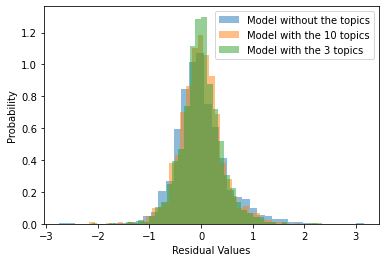

In [85]:
y_mod_3top = model3.resid

plt.hist(y_mod_notop, density=True, bins=40, 
         label = "Model without the topics", alpha=0.5)
plt.hist(y_mod_10top, density=True, bins=40, 
         label = "Model with the 10 topics", alpha=0.5) 
plt.hist(y_mod_3top, density=True, bins=40, 
         label = "Model with the 3 topics", alpha=0.5)
plt.xlabel("Residual Values")
plt.ylabel("Probability")
plt.legend(loc="upper right")

plt.show()

##### 6) Comment on the improvement over the baseline

First of all, it can be seen that the residual histogram of the model with 3 topics shows a more narrow probability distribution compared to the model with 10 topics and the model with no topics, which means it leads to the best fit out of all three.

In [86]:
print("The adjusted R-squared for the model without the topics is:",
      round(model_without_topics.rsquared_adj,3))
print("The adjusted R-squared for the model with the 10 topics is:",
      round(model.rsquared_adj,3))
print("The adjusted R-squared for the model with the 3 topics is:",
      round(model3.rsquared_adj,3))

The adjusted R-squared for the model without the topics is: 0.786
The adjusted R-squared for the model with the 10 topics is: 0.848
The adjusted R-squared for the model with the 3 topics is: 0.865


From the results above, it can be seen that the model with the 3 topics leads to the highest adjusted R-squared value. The fact that the adjusted R-squared value when using 3 topics has increased compared to the case when 10 topics are used could be due to overfitting the model.

In [52]:
#Model with 3 topics compared with the model without topics

mse_notop = model_without_topics.mse_resid
mse_top = model3.mse_resid

(mse_top - mse_notop)/mse_notop

-0.36723402851000125

In [47]:
LOOCV_notop = np.mean((model_without_topics.resid/
                       (1 - model_without_topics.get_influence().hat_matrix_diag))**2)
LOOCV_top = np.mean((model3.resid/
                     (1 - model3.get_influence().hat_matrix_diag))**2)

(LOOCV_top - LOOCV_notop)/LOOCV_notop

-0.3681365761491957

Both the percent decrease in the mean-squared-error (MSE) and the percent decrease in the leave-one-out-cross-validation (LOOCV) error between the model with the 3 topics and the model without topics are higher the the percent decrease for the 10 topic model. This means that the 3 topic model does a better job at predicting the costs than the 10 topic model and the no topic model. The comparison between the 10 topic model and the 3 topic model is given below. This confirms our reasoning.

In [88]:
#Model with 3 topics compared with the model with 10 topics

mse_top10 = model.mse_resid
mse_top3 = model3.mse_resid

(mse_top3 - mse_top10)/mse_top10

-0.10879975879370458

In [89]:
LOOCV_top10 = np.mean((model.resid/
                       (1 - model.get_influence().hat_matrix_diag))**2)
LOOCV_top3 = np.mean((model3.resid/
                      (1 - model3.get_influence().hat_matrix_diag))**2)

(LOOCV_top3 - LOOCV_top10)/LOOCV_top10

-0.11692118422248082

#### 3.7 Interpretation

Now, interpret the model. Use the coefficients of the linear model to 
help interpret the meaning of the topics. Comment on what this says 
about the effectiveness of the topic model for predicting the sale price 
of the house. Does it make intuitive sense? Why or why not?


In general, the models with the topics included performed better at predicting the house prices than the model without topics. As a consequence, one can conclude that there is any additional information hidden in the descriptions of the houses that improves the model of the price. 

**For example in the 10 topic model:**

The first topic ("TOPIC 0") is about buzzwords like kayak, landscape, ny, etc. Attractive things that people like to have as an extra in/around their house. The coefficient for the topic proportion is a positive value, which means that the more this topic is present, the higher the price will be. This makes sense as people like these buzzwords or extra additions to the house. 

The second topic ("TOPIC 1") is about how close or far certain things in the neighborhood are (e.g. location or how far/close the grocery shop is). The coefficient for this topic proportion is negative, which means that if this topic is more present, the price of the housing will drop. This means that the writer of the discription will most likely wrote a negative review about how far everything is. This topic has the highest negative influence out of all the topics.

The topic proportion that has the highest positive influence (positive coefficient) is the seventh topic ("TOPIC 6"). This topic is about nature (sunsets, views, etc.) which definitely has a positive impact on the price.

**For example in the 3 topic model:**

The first topic is about nature, so it makes sense that the coefficient of topic proportion $\theta_0$ is positive. The second topic is about location and has a negative coefficient, so it again might talk about how far certain things are. 

**Conclusion**

Including the discription (by means of using topic proportions as predictor variables) is a good idea and should be included in the final model. One should, however, make sure that not too many topics are included, as this could result to overfitting. From the summary of the 10 topic model, it can for example be seen that topic 7 and topic 8 are not significant. For the final model, one should still find out the optimal amount of topics to include.

### Problem 4: Topic models unite! (20 points)

In this problem we will continue working with topic models, but this time with a new dataset. Instead of real estate listings, we will create topic models over speeches from the United Nations, as described
[here](https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696). 
The dataset was [obtained from Kaggle](https://www.kaggle.com/unitednations/un-general-debates/home), an online community of data scientists. 

In [1]:
import numpy as np
import pandas as pd
import re
import gensim
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

The data are in a CSV format in `un-general-debates.csv`. To read it in you can use the 
function `pd.read_csv`.

In [3]:
%%time
un_data = pd.read_csv('https://sds265.s3.amazonaws.com/un-general-debates.csv')

CPU times: user 1.82 s, sys: 835 ms, total: 2.66 s
Wall time: 38 s


In [4]:
un_data.to_csv("speeches.csv", index=False)

Your task is to build a topic model of these UN speeches.


#### 4.1 Clean and process the data, and fit a topic model.

You can simply copy over the code from Problem 3, and make appropriate modifications here. This time build 
a topic model with 15 topics. Here are some suggestions that may help.

* You can take just the first (say) 5,000 characters of each speech. Take more or less as you see fit. 
* Construct a vocabulary that has no more than 5,000 tokens, by setting a sufficiently high count cutoff for the minimum number of times a word appears in the corpus.
* The above two items will help the topic model train in a reasonable amount of time and memory.

Here are the helper functions used above, just renamed:

In [217]:
def cleanup_speech(desc):
    if type(desc) == float:
        desc = ""
    words = [re.sub(r'[^a-z]', '', w) 
             for w in desc.lower().split(' ')]
    return ' '.join(words)

def reduce_to_vocabulary(desc, vocab):
    return ' '.join([w 
                     for w in cleanup_description(desc).split(' ') 
                     if w in vocab])


In [219]:
vocab = Counter()
for dsc in un_data["text"]:
    vocab.update(cleanup_speech(dsc).split(' '))
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 343432


In [220]:
vocab = Counter(token for token in vocab.elements() 
                if vocab[token] > 211)
stop_words = [item[0] for item 
              in vocab.most_common(340)]
vocab = Counter(token for token in vocab.elements() 
                if token not in stop_words)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 4997


In [221]:
id2word = {idx: pair[0] for idx, pair 
           in enumerate(vocab.items())}
word2id = {pair[0]: idx for idx, pair 
           in enumerate(vocab.items())}

tokens = []
for dsc in un_data["text"]:
    clean = reduce_to_vocabulary(cleanup_speech(dsc)[0:5000], 
                                 vocab)
    toks = clean.split(' ')
    tokens.append(toks)

In [222]:
corpus = []
for toks in tokens:
    tkn_count = Counter(toks)
    corpus.append([(word2id[item[0]], item[1]) 
                   for item in tkn_count.items()])

In [223]:
%%time
tm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=15, 
                                     random_state=100,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

CPU times: user 30.1 s, sys: 12.5 ms, total: 30.1 s
Wall time: 30.1 s


In [224]:
num_topics = 15
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

In [225]:
topic_dist = tm.get_document_topics(corpus[example])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities

Now, complete the processing of the data in order to build a 15-topic model, displaying the top words in each topic.

In [226]:
top_words

,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14
0,1,cent,korea,ago,peacekeeping,dignity,election,afghanistan,island,goals,changes,american,terrorist,iraq,mass,attacks
1,2,globalization,burundi,how,kingdom,values,him,namibia,islands,millennium,detente,latin,ofthe,kuwait,nonproliferation,challenge
2,3,debt,reconciliation,say,operations,nation,congratulations,apartheid,pacific,programme,soviet,caribbean,september,lebanon,destruction,collective
3,4,poor,elections,am,mediation,cultural,tribute,southern,guinea,summit,developments,guyana,acts,aggression,drug,face
4,5,economies,sudan,day,cyprus,equality,behalf,liberation,testing,partnership,asia,guineabissau,fight,islamic,trafficking,sustainable
5,6,markets,korean,then,al,universal,extend,pakistan,adverse,institutions,cold,el,unitednations,palestine,crime,address
6,7,million,unity,violence,majesty,society,pay,angola,solomon,strategy,mutual,salvador,theunited,occupied,hungary,nobel
7,8,billion,cambodia,never,veto,man,appreciation,minority,france,society,whole,honduras,kofi,washington,proliferation,prize
8,9,market,peninsula,know,king,sovereign,predecessor,afghan,ocean,women,era,nicaragua,annan,territories,convention,lack
9,10,industrialized,reunification,why,vii,solidarity,office,grenada,deliberate,commitments,confrontation,display,theinternational,occupation,webelieve,leadership


#### 4.2 Label the Topics

Label each the 15 topics with a short (4 words or less) description. 

In [227]:
labeling = ["Economy, Finance and Industralization",
            "Civil Wars",
            "Connector Words",
            "Monarchs and Sovereign States",
            "Solidarity and Human Rights",
            "Successes and Congratulations",
            "Slaverny, Racism, and Freedom",
            "Caribbean Islands",
            "Achievements and Plans",
            "Cold War Related",
            "Central and South America",
            "Terrorism",
            "Problems in Middle East",
            "Illegal Drug Trafficking",
            "Future Challenges"]
numbering = [i for i in np.arange(15)]

zip_iterator = zip(numbering, labeling)
a_dictionary = dict(zip_iterator)
print(a_dictionary)


{0: 'Economy, Finance and Industralization', 1: 'Civil Wars', 2: 'Connector Words', 3: 'Monarchs and Sovereign States', 4: 'Solidarity and Human Rights', 5: 'Successes and Congratulations', 6: 'Slaverny, Racism, and Freedom', 7: 'Caribbean Islands', 8: 'Achievements and Plans', 9: 'Cold War Related', 10: 'Central and South America', 11: 'Terrorism', 12: 'Problems in Middle East', 13: 'Illegal Drug Trafficking', 14: 'Future Challenges'}


#### 4.3 Table of Topics

Create a function `create_speech_table(data, speeches, corpus, lda_model)` which does the following:
- Goes through every speech and finds the most likely topic for that speech.
- Creates a DataFrame `speech_table` that has the following columns
    - `topic`: the topic number of the most likely topic for each abstract
    - `label`: the topic label of that topic number, which you assigned in part 1
    - `prob`: the probability of that topic number
    - `speech`: a string containing the first 200 characters of the speech
- Show the first 10 rows of the table, then return the table

In [242]:
def create_speech_table(data, speeches, corpus, lda_model):
    n_sp = len(speeches)
    topics_col = np.zeros(n_sp)
    labels_col = []
    prob_col = np.zeros(n_sp)
    speech_col = []
    for i in np.arange(n_sp):
        topic_dist = tm.get_document_topics(corpus[i])
        probabilities = [pair[1] for pair in topic_dist]
        prob_col[i] = np.max(probabilities)
        topics_col[i] = topic_dist[np.argmax(probabilities)][0]
        labels_col.append(labeling[topic_dist[np.argmax(probabilities)][0]])
        speech_col.append(speeches[i][0:200])
    speech_table = pd.DataFrame()
    speech_table["topic"] = topics_col
    speech_table["label"] = labels_col
    speech_table["prob"] = prob_col
    speech_table["speech"] = speech_col
    print(speech_table.head(10))
    return speech_table

#### 4.4 Analysis for selected speeches

Choose at least five speeches and discuss how the assignment of topics either does or does not make sense, according to your own understanding of the speeches and topics.

In [243]:
df_typespeeches = create_speech_table(un_data, 
                                      un_data["text"], 
                                      corpus, tm)

   topic                                  label      prob  \
0    5.0          Successes and Congratulations  0.334689   
1    9.0                       Cold War Related  0.296679   
2    9.0                       Cold War Related  0.394077   
3    8.0                 Achievements and Plans  0.216619   
4    0.0  Economy, Finance and Industralization  0.215844   
5    2.0                        Connector Words  0.353945   
6    5.0          Successes and Congratulations  0.249118   
7    9.0                       Cold War Related  0.334110   
8    9.0                       Cold War Related  0.378043   
9    9.0                       Cold War Related  0.432817   

                                              speech  
0  ﻿It is indeed a pleasure for me and the member...  
1  ﻿\nMay I begin by congratulating you. Sir, on ...  
2  ﻿\nMr. President, it is a particular pleasure ...  
3  ﻿\nDuring the debate at the fortieth session o...  
4  ﻿I should like at the outset to express my del... 

In [244]:
print(df_typespeeches.iloc[0,0:3])
print(df_typespeeches.iloc[0,3])

topic                              5.0
label    Successes and Congratulations
prob                          0.334689
Name: 0, dtype: object
﻿It is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General 


This assignment makes sense, as it is a congratulations speech for Joseph Nanven Garba for his precidency in the United Nations General Assembly from 1989 to 1990.

In [245]:
print(df_typespeeches.iloc[3,0:3])
print(df_typespeeches.iloc[3,3])

topic                       8.0
label    Achievements and Plans
prob                   0.216619
Name: 3, dtype: object
﻿
During the debate at the fortieth session of the General Assembly four years ago, President Sanguinetti announced to the world community from this very rostrum that Uruguay had resumed its tradition


This assignment also makes sense, as the speech is about Sanguinetti (Former President of Uruguay) and his plans to improve the country


In [246]:
print(df_typespeeches.iloc[7502,0:3])
print(df_typespeeches.iloc[7502,3])

topic         11.0
label    Terrorism
prob      0.356097
Name: 7502, dtype: object
﻿This session
that is taking place under extraordinary circumstances,
when the whole world is still reeling in shock from the
world’s most terrible terrorist attacks, carried out in
New York and Washi


This assignment makes sense, as it talks about the 9/11 attacks and terrorism related content.

In [247]:
print(df_typespeeches.iloc[7506,0:3])
print(df_typespeeches.iloc[7506,3])

topic         11.0
label    Terrorism
prob      0.293997
Name: 7506, dtype: object
﻿On behalf of the State of Kuwait, it
gives me pleasure to congratulate Mr. Han Seung-soo,
and his friendly country, the Republic of Korea, on his
election as President of the fifty-sixth session of t


This assignment makes less sense, as it is more about congratulating someone than a terrorist attack. Assigning it 5: 'Successes and Congratulations' would make more sense.

In [248]:
print(df_typespeeches.iloc[748,0:3])
print(df_typespeeches.iloc[748,3])

topic                 9.0
label    Cold War Related
prob             0.243547
Name: 748, dtype: object
﻿At the outset, I would like to congratulate you, Sir, on your election to the presidency of the General Assembly for this session. I have no doubt that, like your predecessor, you will guide its proc


This assignment makes sense, as the speech is about welcoming the Republic of Korea after the Cold War